<a href="https://colab.research.google.com/github/Bandi120424/KDT-AI/blob/Month-3/Titainic_Classification_via_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ML Pipeline 기반 머신러닝 모델 만들기
- Titainic 생존여부예측 모델

In [70]:
!pip install pyspark==3.0.1 py4j==0.10.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .config("/content/pmml-sparkml-example-executable-2.2.0.jar") \
    .appName("Titainic Classification via ML Pipeline") \
    .getOrCreate()

In [78]:
spark

## 데이터 준비

In [74]:
!wget https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv

--2023-01-03 05:17:18--  https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv
Resolving s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)... 52.92.194.234, 52.218.235.25, 52.218.216.97, ...
Connecting to s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)|52.92.194.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61197 (60K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K   377KB/s    in 0.2s    

2023-01-03 05:17:19 (377 KB/s) - ‘titanic.csv’ saved [61197/61197]



In [76]:
%cd

/root


In [79]:
!ls -tl #파일 확인

total 60
-rw-r--r-- 1 root root 61197 Mar 17  2022 titanic.csv


데이터 -> 데이터프레임으로 로딩

In [8]:
data = spark.read.csv("./titanic.csv", header = True, inferSchema = True)

In [9]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [10]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|Gender| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [11]:
data.select(['*']).describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|Gender|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

### 데이터 클린업


*   **feature 선택**
  * PassengerID, Name, Ticket, Embarked: 생존 여부와 크게 상관없은 feature => 사용 X
* **결측치처리**  
  * Cabin: 결측치가 많으므로 사용하지 않음 
  * Age: 생존 여부와 유의미한 관계 -> 결측치를 특정 값으로 채워줌
* **스케일링**
  * MinMaxScaler 
* **범주형 변수 처리**
  * Gender: 숫자로 인코딩





#### 결측치 확인

In [12]:
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----------+--------+------+----+------+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Gender|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+------+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|     0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+------+---+-----+-----+------+----+-----+--------+



#### feature 선택 
새로운 데이터 프레임으로 정의

In [13]:
new_feats = [ x for x in data.columns if x not in ['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin']]
new_feats

['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare']

In [14]:
final_data = data[new_feats]

In [15]:
final_data.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


#### 결측치 처리
- Age: 평균값으로 채움

In [16]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy='mean', inputCols = ['Age'], outputCols = ['AgeImputed'])
imputer_model = imputer.fit(final_data)
final_data = imputer_model.transform(final_data)

In [17]:
final_data = imputer_model.transform(final_data)

In [18]:
final_data.select('Age', 'AgeImputed').show()

+----+-----------------+
| Age|       AgeImputed|
+----+-----------------+
|22.0|             22.0|
|38.0|             38.0|
|26.0|             26.0|
|35.0|             35.0|
|35.0|             35.0|
|null|29.69911764705882|
|54.0|             54.0|
| 2.0|              2.0|
|27.0|             27.0|
|14.0|             14.0|
| 4.0|              4.0|
|58.0|             58.0|
|20.0|             20.0|
|39.0|             39.0|
|14.0|             14.0|
|55.0|             55.0|
| 2.0|              2.0|
|null|29.69911764705882|
|31.0|             31.0|
|null|29.69911764705882|
+----+-----------------+
only showing top 20 rows



#### 범주형 변수 처리
- Gender: 숫자로 인코딩 (male: 0, female: 1)

In [19]:
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol = 'Gender', outputCol = 'GenderIndexed')
gender_indexer_model = gender_indexer.fit(final_data)
final_data = gender_indexer_model.transform(final_data)

In [20]:
final_data.select("Gender", 'GenderIndexed').show()

+------+-------------+
|Gender|GenderIndexed|
+------+-------------+
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
+------+-------------+
only showing top 20 rows



#### feature 벡터 생성

In [21]:
final_feats = [ x for x in final_data.columns if x not in ['Age', 'Gender', 'Survived']]
final_feats

['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed']

In [22]:
from pyspark.ml.feature import VectorAssembler 

assembler = VectorAssembler(inputCols = final_feats, outputCol = 'features')
data_vec = assembler.transform(final_data)

In [23]:
data_vec.show()

+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|       AgeImputed|GenderIndexed|            features|
+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|             22.0|          0.0|[3.0,1.0,0.0,7.25...|
|       1|     1|female|38.0|    1|    0|71.2833|             38.0|          1.0|[1.0,1.0,0.0,71.2...|
|       1|     3|female|26.0|    0|    0|  7.925|             26.0|          1.0|[3.0,0.0,0.0,7.92...|
|       1|     1|female|35.0|    1|    0|   53.1|             35.0|          1.0|[1.0,1.0,0.0,53.1...|
|       0|     3|  male|35.0|    0|    0|   8.05|             35.0|          0.0|[3.0,0.0,0.0,8.05...|
|       0|     3|  male|null|    0|    0| 8.4583|29.69911764705882|          0.0|[3.0,0.0,0.0,8.45...|
|       0|     1|  male|54.0|    0|    0|51.8625|             54.0|      

#### 스케일링
Age와 Fare의 값을 스케일링: MInMaxScaler 사용

In [24]:
from pyspark.ml.feature import MinMaxScaler

age_scaler = MinMaxScaler(inputCol = 'features', outputCol = 'features_scaled')
age_scaler_model = age_scaler.fit(data_vec)
data_vec = age_scaler_model.transform(data_vec)

In [25]:
data_vec.select('features', 'features_scaled').show()

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,0.0,0.0,8.45...|[1.0,0.0,0.0,0.01...|
|[1.0,0.0,0.0,51.8...|(6,[3,4],[0.10122...|
|[3.0,3.0,1.0,21.0...|[1.0,0.375,0.1666...|
|[3.0,0.0,2.0,11.1...|[1.0,0.0,0.333333...|
|[2.0,1.0,0.0,30.0...|[0.5,0.125,0.0,0....|
|[3.0,1.0,1.0,16.7...|[1.0,0.125,0.1666...|
|[1.0,0.0,0.0,26.5...|[0.0,0.0,0.0,0.05...|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,1.0,5.0,31.2...|[1.0,0.125,0.8333...|
|[3.0,0.0,0.0,7.85...|[1.0,0.0,0.0,0.01...|
|[2.0,0.0,0.0,16.0...|[0.5,0.0,0.0,0.03...|
|[3.0,4.0,1.0,29.1...|[1.0,0.5,0.166666...|
|[2.0,0.0,0.0,13.0...|[0.5,0.0,0.0,0.02...|
|[3.0,1.0,0.0,18.0...|[1.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.22...|[1.0,0.0,0

In [26]:
data_vec.show()

+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+--------------------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|       AgeImputed|GenderIndexed|            features|     features_scaled|
+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|             22.0|          0.0|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|       1|     1|female|38.0|    1|    0|71.2833|             38.0|          1.0|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|       1|     3|female|26.0|    0|    0|  7.925|             26.0|          1.0|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|       1|     1|female|35.0|    1|    0|   53.1|             35.0|          1.0|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|       0|     3|  male|35.0|    0|    0|   8.05|             35.0|          0.0|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|       

## 모델 훈련

훈련, 테스트 데이터 분리 

In [27]:
train, test = data_vec.randomSplit([0.7, 0.3])

모델 생성

In [28]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'Survived')
model = algo.fit(train)

### 모델 성능 측정

In [29]:
predictions = model.transform(test)
predictions.groupby(['Survived']).count().collect()

[Row(Survived=1, count=107), Row(Survived=0, count=171)]

In [30]:
predictions.groupby(['prediction']).count().collect() #prediction 예측 비율

[Row(prediction=0.0, count=183), Row(prediction=1.0, count=95)]

In [31]:
predictions.select(['Survived', 'prediction', 'probability']).show()

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.07003832590959...|
|       0|       1.0|[0.09869639678791...|
|       0|       1.0|[0.45886762954252...|
|       0|       1.0|[0.46700398677515...|
|       0|       1.0|[0.46736321977784...|
|       0|       1.0|[0.46959741941252...|
|       0|       1.0|[0.47186994536041...|
|       0|       1.0|[0.40646883654519...|
|       0|       1.0|[0.42721173627224...|
|       0|       0.0|[0.51052492175456...|
|       0|       1.0|[0.47024815759162...|
|       0|       1.0|[0.48682108702216...|
|       0|       1.0|[0.49199068155100...|
|       0|       0.0|[0.53155944834869...|
|       0|       0.0|[0.63754804039149...|
|       0|       0.0|[0.68033217160983...|
|       0|       0.0|[0.61185670786826...|
|       0|       0.0|[0.71507094862391...|
|       0|       0.0|[0.63206802439476...|
|       0|       0.0|[0.76819904926273...|
+--------+-

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol = 'Survived', metricName = 'areaUnderROC')
evaluator.evaluate(predictions)

0.8391812865497077

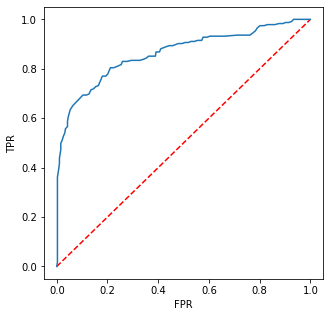

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.plot([0,1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## ML Pipeline 만들기

위 과정을 pipeline으로 간편하게 해보자

In [34]:
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, MinMaxScaler

imputer = Imputer(strategy = 'mean', inputCols = ['Age'], outputCols = ['AgeImputed'])
stringIndexer = StringIndexer(inputCol = 'Gender', outputCol = 'GenderIndexed')
assembler = VectorAssembler(inputCols = final_feats, outputCol = 'features')
minmax_scaler = MinMaxScaler(inputCol = 'features', outputCol = 'features_scaled')

stages = [imputer, stringIndexer, assembler, minmax_scaler]

In [35]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'Survived')
lr_stages = stages + [algo]

In [36]:
lr_stages

[Imputer_0ba2e2b1da25,
 StringIndexer_2e414413f40a,
 VectorAssembler_cccbf7c0b2f4,
 MinMaxScaler_d80c83dd00d5,
 LogisticRegression_9d150b5a523d]

In [37]:
from pyspark.ml import Pipeline 
pipeline = Pipeline(stages = lr_stages)

In [38]:
new_feats = [ x for x in data.columns if x not in ['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin']]
new_feats

['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare']

In [39]:
df = data.select(new_feats)
df.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


훈련, 테스트 데이터 분리

In [40]:
train, test = df.randomSplit([0.7, 0.3])

In [41]:
lr_model = pipeline.fit(train)
lr_cv_predictions = lr_model.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8623847456564017

## ML Tuning

최적의 하이퍼파라미터 찾기

In [42]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Survived', metricName = 'areaUnderROC')

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
              .addGrid(algo.maxIter, [1, 5, 10])
              .build())

cv = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = paramGrid,
    evaluator = evaluator,
    numFolds = 5
)

In [44]:
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8608166593489315

In [45]:
lr_cv_predictions.select('prediction', 'Survived').show()

+----------+--------+
|prediction|Survived|
+----------+--------+
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
+----------+--------+
only showing top 20 rows



하이퍼 파라미터별 score 출력

In [46]:
import pandas as pd 

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cvModel.avgMetrics)   
])

,areaUnderROC,maxIter
0,0.825985,1
1,0.846101,5
2,0.846660,10


GBT Classifier 사용
- Gradient-Boosted Trees (GBTs)

In [47]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features_scaled', labelCol = 'Survived')
gbt_stages = stages + [gbt]

In [48]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = gbt_stages)

In [49]:
gbt_stages

[Imputer_0ba2e2b1da25,
 StringIndexer_2e414413f40a,
 VectorAssembler_cccbf7c0b2f4,
 MinMaxScaler_d80c83dd00d5,
 GBTClassifier_37a64ddddbf8]

In [50]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
              .addGrid(gbt.maxDepth, [2, 4, 6])
              .addGrid(gbt.maxBins, [20, 60])
              .addGrid(gbt.maxIter, [10, 20])
              .build())

cv = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = paramGrid,
    evaluator = evaluator,
    numFolds = 5
)

In [51]:
cvModel = cv.fit(train)
gbt_cv_predictions = cvModel.transform(test)
evaluator.evaluate(gbt_cv_predictions)

0.8692843254092705